# Signal modelling and source separation - Auto-regressive models

This notebook trains signal models and performs source separation for multiple signals.

The signal model is given as
$$ p(y^n_k \mid x^n_k, \ \gamma_v) = \mathcal{N}(y_k^n \mid x^n_k, \ \gamma_v^{-1})$$
$$ p(x_k^n \mid x_{k-P:k-1}^n, \ \theta_{1:p}^n, \ \gamma_w) = \mathcal{N}\left(x_k^n \mid \sum_{p=1}^P \theta^n_p x_{k-p}^n, \ \gamma_w^{-1}\right)$$

The observation model is given as
$$ p(y_k \mid x^{1:N}_k, \ \gamma_y) = \mathcal{N}\left(y_k \mid \sum_{n=1}^N x^n_k, \ \gamma_y^{-1}\right)$$
$$ p(x_k^n \mid x_{k-P:k-1}^n, \ \theta_{1:p}^n, \ \gamma_w) = \mathcal{N}\left(x_k^n \mid \sum_{p=1}^P \theta^n_p x_{k-p}^n, \ \gamma_w^{-1}\right)$$

Limitations:
* non-stationary
* precision at non-zero frequencies cannot be improved by adding poles -> AR prior on fourier coefs

## Load packages

In [26]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using ForneyLab
using LAR
using LAR.Node
using LinearAlgebra
using PyPlot
using Compat
using WAV
using Base64
using DSP
using FFTW
using ProgressMeter
using Printf
using HDF5
using Distributions
using StatsBase

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl")
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


## Parameters

In [9]:
# signal definition
sound_files = ["../data/sin1000.wav",            # specify sound sources to model and separate (can be more than 2)
               "../data/sin2000.wav",
               "../data/sin3000.wav"]
fs_desired = 8000                              # specify desired sampling frequency of signals
duration = 3                                   # specify duration of training signals
normalization_method = "max"                   # specify method to use for normalizing the signals

# save folders
folder_params = "inferred/AR_model"            # specify folder to save inferred values in (to save time when recomputing)
folder_figures = "figures/AR_model"            # specify folder to save figures in

# inference and modelling
AR_order = 5                                   # order of auto-regressive model
iterations = 5                                 # number of iterations for variational message passing
γ_meas_train = 1e4                             # assumed precision of measurement noise during training
γ_meas_sep = 1e4                               # assumed precision of measurement noise during source separation
;

## Load and preprocess data

In [10]:
# create array for time signals
signal = Array{Array{Float64,1},1}(undef, length(sound_files))

# load signals, preprocess, crop and save
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration)*fs_tmp]
    
    # preprocess signal and save
    signal[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
        
end

# create mixture signal 
ymix = sum(signal)

# create time axis
t = collect(1:length(ymix))/fs_desired
;

## Visualise signals

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQDmiqE9jrsxP87/fz/q4DM/AT6nOvGHNL8Z5n6/63s0vxNNejkKQTQ/zRt/P9VSND8gfXg5jVo0v84Hf7/lYjS/MW6QuHdQND8CDn8/0Vk0P4KYlLeOWTS/4Q1/v3VaNL/zsEg2KVk0P5wNfz9QWjQ/stZWtyVZNL9ZDn+/Nlo0v0MCJbUAWDQ/BQ5/P+5aND/SZVY2+lc0v4gOf78vWzS/nNBHtmFZND8kDn8/llc0P8OBGbdSWzS/aQ5/v2RYNL9TMLO20lk0P/UNfz/BWDQ/ydzlNrNaNL8ADn+/jVk0v4sUFrcRWjQ/fQ1/PypZND+3SEU3NVo0v2YOf7/3WDS//i2ltxRaND8bDn8/T1k0PxuYvzc1WjS/FA9/v9FZNL+4zcu3tFk0P3oNfz83WTQ/lkDON0BaNL+nDX+/kFo0v5zQR7YtWjQ/Dw1/P9xZND9fGgC4m1k0v94Nf78YWjS/kdmZN21ZND+wDn8/0Vk0P0KM8bezWTS/fw5/v3daNL+vc2Y3k1g0PwIOfz/RWTQ/gpiUt45ZNL/hDX+/dVo0v/OwSDYpWTQ/nA1/P1BaND+y1la3JVk0v1kOf782WjS/QwIltQBYND8FDn8/7lo0P9JlVjb6VzS/iA5/vy9bNL+c0Ee2YVk0PyQOfz+WVzQ/w4EZt1JbNL9pDn+/ZFg0v1Mws7bSWTQ/9Q1/P8FYND/J3OU2s1o0vwAOf7+NWTS/ixQWtxFaND99DX8/Klk0P7dIRTc1WjS/Zg5/v/dYNL/+LaW3FFo0PxsOfz9PWTQ/G5i/NzVaNL8UD3+/0Vk0v7jNy7e0WTQ/eg1/PzdZND+WQM43QFo0v6cNf7+QWjS/nNBHti1aND8PDX8/3Fk0P18aALibWTS/3g1/vxhaNL+R2Zk3bVk0P7AOfz/RWTQ/Qozxt7NZNL9/Dn+/d1o0v69zZjeTWDQ/Ag5/P9FZND+CmJS3jlk0v+ENf791WjS/87BINilZND+cDX8/UFo0P7LWVrclWTS/WQ5/vzZaNL9DAiW1AFg0PwUOfz/uWjQ/0mVWNvpXNL+IDn+/L1s0v5zQR7ZhWTQ/JA5/P5ZXND/DgRm3Uls0v2kOf79kWDS/UzCzttJZND/1DX8/wVg0P8nc5TazWjS/AA5/v41ZNL+LFBa3EVo0P30Nfz8qWTQ/t0hFNzVaNL9mDn+/91g0v/4tpbcUWjQ/Gw5/P09ZND8bmL83NVo0vxQPf7/RWTS/uM3Lt7RZND96DX8/N1k0P5ZAzjdAWjS/pw1/v5BaNL+c0Ee2LVo0Pw8Nfz/cWTQ/XxoAuJtZNL/eDX+/GFo0v5HZmTdtWTQ/sA5/P9FZND9CjPG3s1k0v38Of793WjS/r3NmN5NYND8CDn8/0Vk0P4KYlLeOWTS/4Q1/v3VaNL/zsEg2KVk0P5wNfz9QWjQ/stZWtyVZNL9ZDn+/Nlo0v0MCJbUAWDQ/BQ5/P+5aND/SZVY2+lc0v4gOf78vWzS/nNBHtmFZND8kDn8/llc0P8OBGbdSWzS/aQ5/v2RYNL9TMLO20lk0P/UNfz/BWDQ/ydzlNrNaNL8ADn+/jVk0v4sUFrcRWjQ/fQ1/PypZND+3SEU3NVo0v2YOf7/3WDS//i2ltxRaND8bDn8/T1k0PxuYvzc1WjS/FA9/v9FZNL+4zcu3tFk0P3oNfz83WTQ/lkDON0BaNL+nDX+/kFo0v5zQR7YtWjQ/Dw1/P9xZND9fGgC4m1k0v94Nf78YWjS/kdmZN21ZND+wDn8/0Vk0P0KM8bezWTS/fw5/v3daNL+vc2Y3k1g0PwIOfz/RWTQ/gpiUt45ZNL/hDX+/dVo0v/OwSDYpWTQ/nA1/P1BaND+y1la3JVk0v1kOf782WjS/QwIltQBYND8FDn8/7lo0P9JlVjb6VzS/iA5/vy9bNL+c0Ee2YVk0PyQOfz+WVzQ/w4EZt1JbNL9pDn+/ZFg0v1Mws7bSWTQ/9Q1/P8FYND/J3OU2s1o0vwAOf7+NWTS/ixQWtxFaND99DX8/Klk0P7dIRTc1WjS/Zg5/v/dYNL/+LaW3FFo0PxsOfz9PWTQ/G5i/NzVaNL8UD3+/0Vk0v7jNy7e0WTQ/eg1/PzdZND+WQM43QFo0v6cNf7+QWjS/nNBHti1aND8PDX8/3Fk0P18aALibWTS/3g1/vxhaNL+R2Zk3bVk0P7AOfz/RWTQ/Qozxt7NZNL9/Dn+/d1o0v69zZjeTWDQ/Ag5/P9FZND+CmJS3jlk0v+ENf791WjS/87BINilZND+cDX8/UFo0P7LWVrclWTS/WQ5/vzZaNL9DAiW1AFg0PwUOfz/uWjQ/0mVWNvpXNL+IDn+/L1s0v5zQR7ZhWTQ/JA5/P5ZXND/DgRm3Uls0v2kOf79kWDS/UzCzttJZND/1DX8/wVg0P8nc5TazWjS/AA5/v41ZNL+LFBa3EVo0P30Nfz8qWTQ/t0hFNzVaNL9mDn+/91g0v/4tpbcUWjQ/Gw5/P09ZND8bmL83NVo0vxQPf7/RWTS/uM3Lt7RZND96DX8/N1k0P5ZAzjdAWjS/pw1/v5BaNL+c0Ee2LVo0Pw8Nfz/cWTQ/XxoAuJtZNL/eDX+/GFo0v5HZmTdtWTQ/sA5/P9FZND9CjPG3s1k0v38Of793WjS/r3NmN5NYND8CDn8/0Vk0P4KYlLeOWTS/4Q1/v3VaNL/zsEg2KVk0P5wNfz9QWjQ/stZWtyVZNL9ZDn+/Nlo0v0MCJbUAWDQ/BQ5/P+5aND/SZVY2+lc0v4gOf78vWzS/nNBHtmFZND8kDn8/llc0P8OBGbdSWzS/aQ5/v2RYNL9TMLO20lk0P/UNfz/BWDQ/ydzlNrNaNL8ADn+/jVk0v4sUFrcRWjQ/fQ1/PypZND+3SEU3NVo0v2YOf7/3WDS//i2ltxRaND8bDn8/T1k0PxuYvzc1WjS/FA9/v9FZNL+4zcu3tFk0P3oNfz83WTQ/lkDON0BaNL+nDX+/kFo0v5zQR7YtWjQ/Dw1/P9xZND9fGgC4m1k0v94Nf78YWjS/kdmZN21ZND+wDn8/0Vk0P0KM8bezWTS/fw5/v3daNL+vc2Y3k1g0PwIOfz/RWTQ/gpiUt45ZNL/hDX+/dVo0v/OwSDYpWTQ/nA1/P1BaND+y1la3JVk0v1kOf782WjS/QwIltQBYND8FDn8/7lo0P9JlVjb6VzS/iA5/vy9bNL+c0Ee2YVk0PyQOfz+WVzQ/w4EZt1JbNL9pDn+/ZFg0v1Mws7bSWTQ/9Q1/P8FYND/J3OU2s1o0vwAOf7+NWTS/ixQWtxFaND99DX8/Klk0P7dIRTc1WjS/Zg5/v/dYNL/+LaW3FFo0PxsOfz9PWTQ/G5i/NzVaNL8UD3+/0Vk0v7jNy7e0WTQ/eg1/PzdZND+WQM43QFo0v6cNf7+QWjS/nNBHti1aND8PDX8/3Fk0P18aALibWTS/3g1/vxhaNL+R2Zk3bVk0P7AOfz/RWTQ/Qozxt7NZNL9/Dn+/d1o0v69zZjeTWDQ/Ag5/P9FZND+CmJS3jlk0v+ENf791WjS/87BINilZND+cDX8/UFo0P7LWVrclWTS/WQ5/vzZaNL9DAiW1AFg0PwUOfz/uWjQ/0mVWNvpXNL+IDn+/L1s0v5zQR7ZhWTQ/JA5/P5ZXND/DgRm3Uls0v2kOf79kWDS/UzCzttJZND/1DX8/wVg0P8jc5TazWjS/AA5/v41ZNL+LFBa3EVo0P30Nfz8qWTQ/t0hFNzVaNL9mDn+/91g0v/4tpbcUWjQ/Gw5/P09ZND8bmL83NVo0vxQPf7/RWTS/uM3Lt7RZND96DX8/N1k0P5ZAzjdAWjS/pw1/v5BaNL+c0Ee2LVo0Pw8Nfz/cWTQ/XxoAuJtZNL/eD

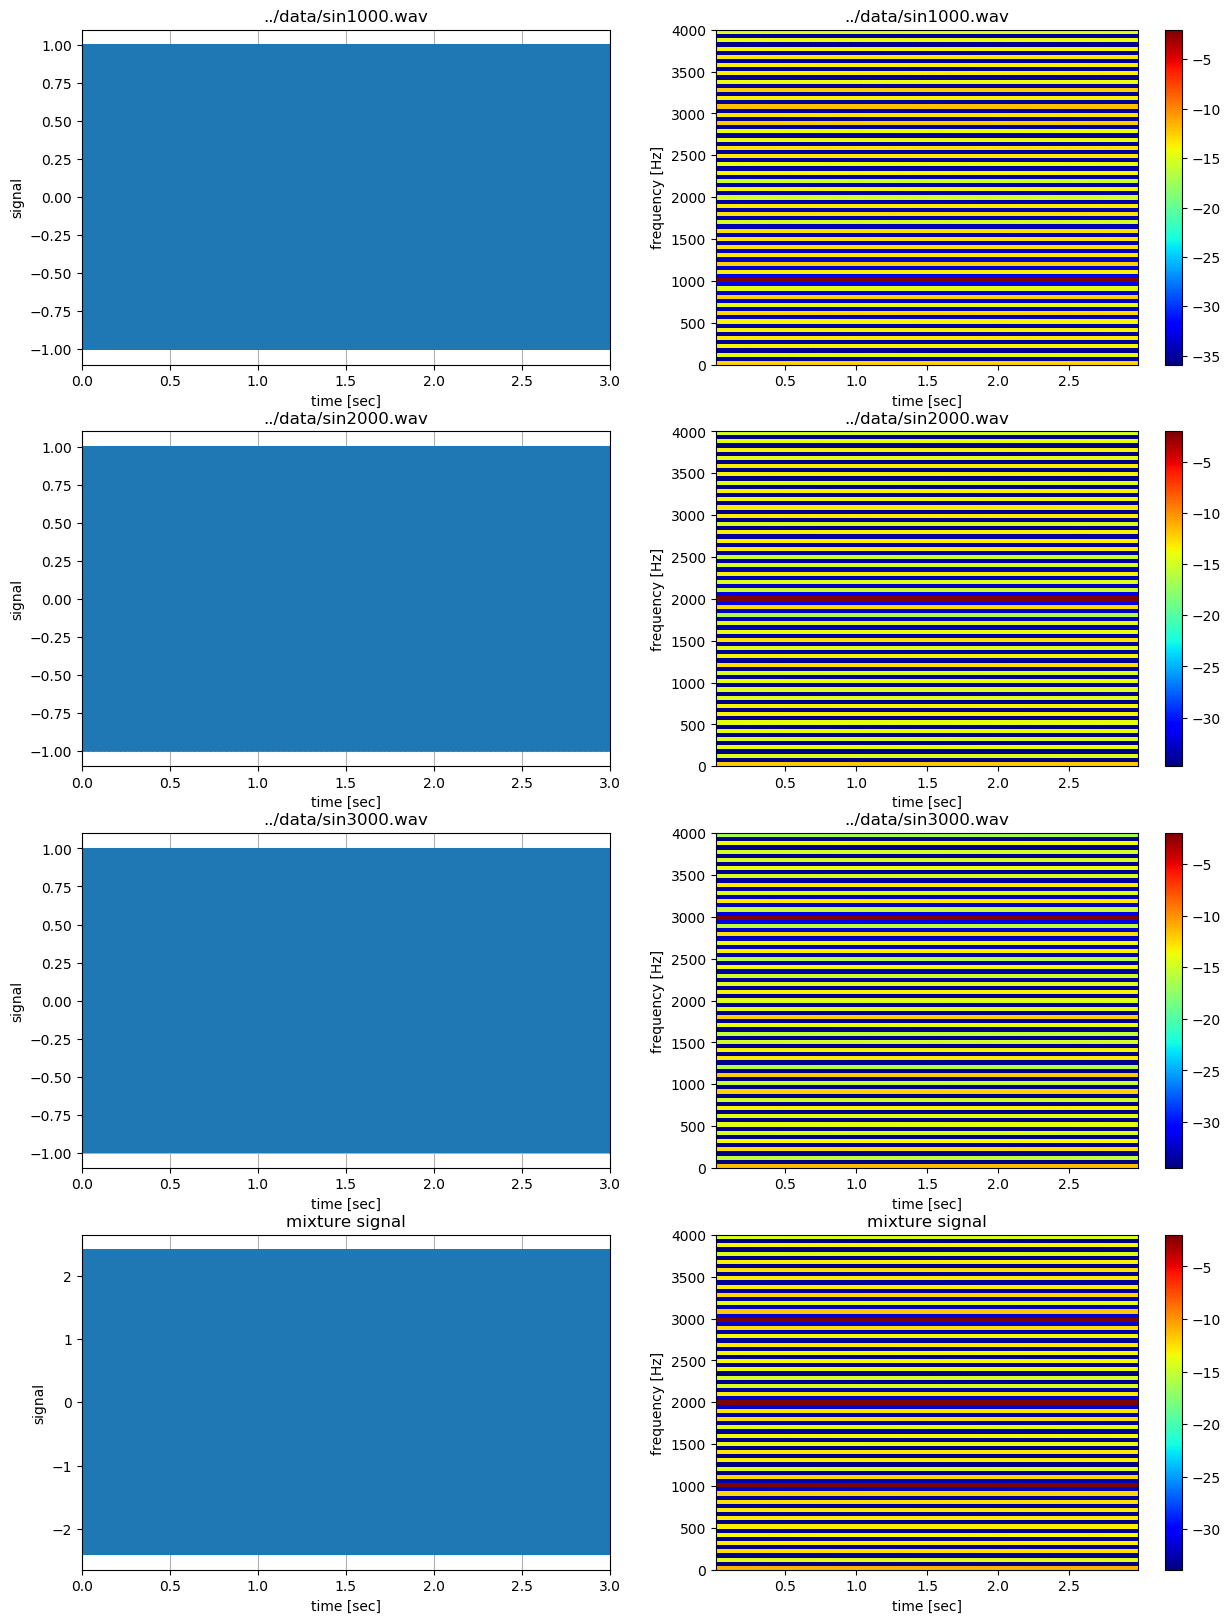

In [11]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files)+1, figsize=(15, 5*(length(sound_files)+1)))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t, signal[k]), ax[k,1].set_xlim([0, duration]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k])
    
    # plot spectrogram of signal
    plot_spectrogram(spectrogram(signal[k], 160, 80, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true), ax[k,2].set_title(sound_files[k])

end

# finally add mixture signals
ax[end,1].plot(t, ymix), ax[end,1].set_xlim([0, duration]), ax[end,1].set_xlabel("time [sec]"), ax[end,1].set_ylabel("signal"), ax[end,1].grid(), ax[end,1].set_title("mixture signal")
plot_spectrogram(spectrogram(ymix, 160, 80, fs=fs_desired), fs_desired, ax=ax[end,2], colorbar=true), ax[end,2].set_title("mixture signal")

# create audioplayers
audioplayers(signal..., ymix, fs=fs_desired)
;

## Define signal model

In [12]:
# create expression that can draw an entire graph in a factor graph statement
function signal_model(k, AR_order)
    
    # wrap code into an expression to execute later on in a factor graph type to allow for modularity
    model = quote
        
        # create dictionary for variables
        if !@isdefined vars
            vars = Dict()
        end
        
        # Auto-regressive (AR) node
        @RV [id=pad(:γ,$k)] vars[pad(:γ,$k)] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,$k)), placeholder(pad(:b_γ,$k)))
        @RV [id=pad(:θ,$k)] vars[pad(:θ,$k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_θ,$k), dims=($AR_order,)), placeholder(pad(:Λ_θ,$k), dims=($AR_order, $AR_order)))
        @RV [id=pad(:Sprev,$k)] vars[pad(:Sprev,$k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_Sprev,$k), dims=($AR_order,)), placeholder(pad(:Λ_Sprev,$k), dims=($AR_order, $AR_order)))
        @RV [id=pad(:S,$k)] vars[pad(:S,$k)] ~ LAR.Autoregressive(vars[pad(:θ,$k)], vars[pad(:Sprev,$k)], vars[pad(:γ,$k)])

        # select from buffer to form input
        d = zeros($AR_order)
        d[1] = 1
        @RV [id=pad(:x,$k)] vars[pad(:x,$k)] ~ DotProduct(d, vars[pad(:S,$k)])
        
        # create recognition factor
        q = ForneyLab.PosteriorFactorization(vars[pad(:θ,$k)], [vars[pad(:S,$k)], vars[pad(:Sprev,$k)]], vars[pad(:γ,$k)], ids=[:θ :S :γ])
    
    # end expression
    end 
       
    # return expression
    return model
    
end
;

## Train models or load parameters

In [13]:
function load_priors(k, AR_order; mode="training")
    
    # create dictionary of priors
    if mode == "training"
        priors = Dict(pad(:a_γ, k) => 0.1,
                      pad(:b_γ, k) => 0.001,
                      pad(:μ_Sprev, k) => zeros(AR_order),
                      pad(:Λ_Sprev, k) => 1e-2*Ic(AR_order),
                      pad(:μ_θ, k) => randn(AR_order),
                      pad(:Λ_θ, k) => 1e-8*Ic(AR_order))
    elseif mode == "separation"
        priors = Dict()
        for ki in k
            priors[pad(:μ_Sprev, ki)] = zeros(AR_order)
            priors[pad(:Λ_Sprev, ki)] = 1e-2*Ic(AR_order)
        end
    end
    
    # return priors
    return priors
    
end
;

In [14]:
function load_marginals(k, AR_order)
    
    # create dictionary of marginals
    marginals = Dict()
    for ki in k
        marginals[pad(:γ, ki)] = vague(ForneyLab.Gamma)
        marginals[pad(:Sprev, ki)] = vague(GaussianMeanPrecision, AR_order)
        #marginals[pad(:S, ki)] = vague(GaussianMeanPrecision, AR_order)
        marginals[pad(:θ, ki)] = vague(GaussianMeanPrecision, AR_order)
    end
    
    # return marginals
    return marginals
    
end
;

In [15]:
function train_model(k, model, priors, marginals, signal, hyper, iterations)
    
    # create factor graph
    FactorGraph()
    
    # create model
    eval(model)
    
    # add observation noise
    @RV y ~ GaussianMeanPrecision(vars[pad(:x,k)], placeholder(:γ_meas))
    
    # create output samples
    placeholder(y, :y)
    
    # create algorithm
    algo = variationalAlgorithm(q)
    source_code = compatibility_fix(algorithmSourceCode(algo))
    eval(Meta.parse(source_code))
        
    # create arrays for current estimates
    data = merge(priors, hyper)

    # get dictionary of currently inferred values 
    vals = Dict()
    
    # loop through data
    for n = 1:length(signal)

       
        # fill data dictionary
        data = merge(data, vals, Dict(:y => signal[n]))

        # perform updates
        for _ = 1:iterations

            # perform inference
            Base.invokelatest(stepS!, data, marginals)
            Base.invokelatest(stepγ!, data, marginals)
            Base.invokelatest(stepθ!, data, marginals)

        end
        
        # get new values
        for ki in k
            vals[pad(:μ_θ, ki)] = ForneyLab.unsafeMean(marginals[pad(:θ, ki)])
            vals[pad(:Λ_θ, ki)] = ForneyLab.unsafePrecision(marginals[pad(:θ, ki)])
            vals[pad(:μ_Sprev, ki)] = ForneyLab.unsafeMean(marginals[pad(:S, ki)*pad(:_Sprev,ki)])[1:AR_order]
            vals[pad(:Λ_Sprev, ki)] = inv(ForneyLab.unsafeCov(marginals[pad(:S, ki)*pad(:_Sprev,ki)])[1:AR_order,1:AR_order])
            vals[pad(:a_γ, ki)] = marginals[pad(:γ,ki)].params[:a]
            vals[pad(:b_γ, ki)] = marginals[pad(:γ,ki)].params[:b]
        end
        
    end

    return vals
    
end
;

In [16]:
# create placeholder for parameters
params = Array{Dict, 1}(undef, length(sound_files))

# loop through signals
@showprogress for k = 1:length(sound_files)
    
    # check whether parameters have already been inferred
    filename = folder_params*"/AR_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*string(AR_order, pad=2)*"_"*@sprintf("%.1E", γ_meas_train)*".h5"
    if isfile(filename)
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        println("For signal "*string(k)*" the parameters have been found and loaded.")
        
    else
        
        # train models and save parameters
        println("For signal "*string(k)*" the parameters have not been found and are now being trained...")
        
        # load graph
        model = signal_model(k, AR_order)
        
        # specify priors
        priors = load_priors(k, AR_order)
        
        # specify marginals
        marginals = load_marginals(k, AR_order)
        
        # specify hyperparameters
        hyper = Dict(:γ_meas => γ_meas_train)
        
        # train model
        vals = train_model(k, model, priors, marginals, signal[k], hyper, iterations)
        
        # save parameters
        h5open(filename, "w") do file
            write(file, "parameters/a_gamma", vals[pad(:a_γ, k)])
            write(file, "parameters/b_gamma", vals[pad(:b_γ, k)]) 
            write(file, "parameters/mean_theta", vals[pad(:μ_θ, k)]) 
            write(file, "parameters/precision_theta", vals[pad(:Λ_θ, k)]) 
        end
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        
        # return statement of completion
        println("For signal "*string(k)*" the parameters have now been trained and saved for later use.")
        
    end
    
end

Progress:  33%|██████████████                           |  ETA: 0:00:02

For signal 1 the parameters have been found and loaded.
For signal 2 the parameters have been found and loaded.
For signal 3 the parameters have been found and loaded.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


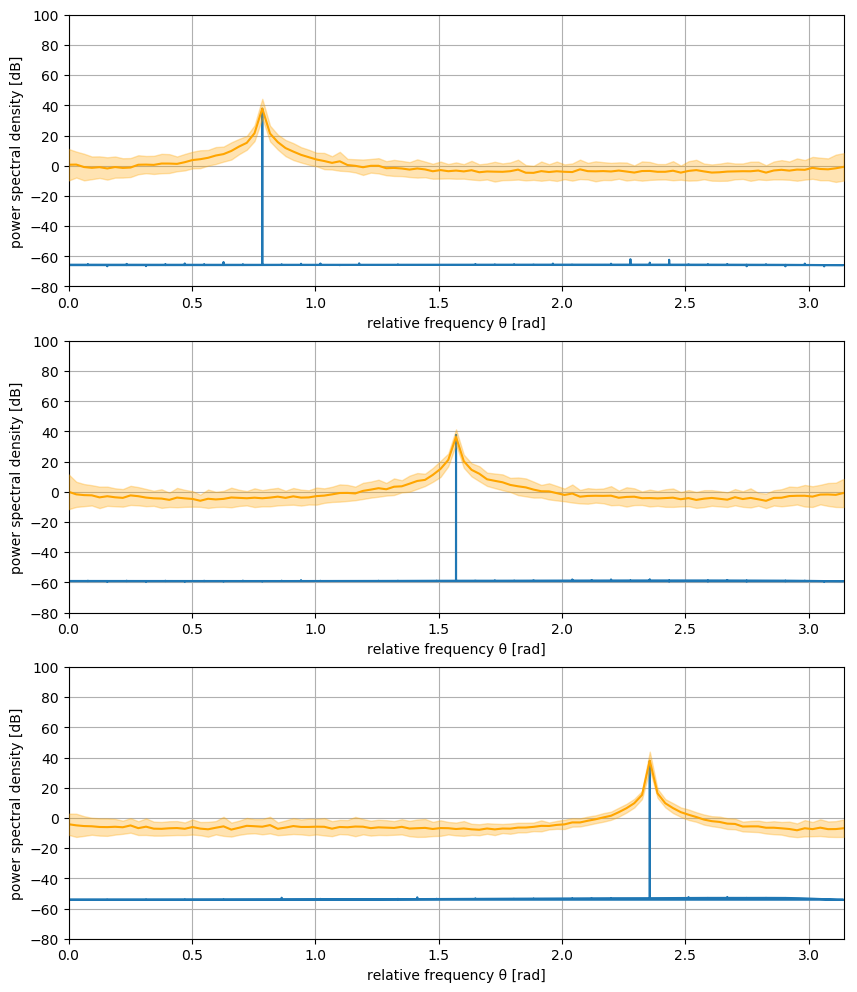

In [17]:
# create figure
_, ax = plt.subplots(nrows = length(sound_files), figsize=(10,4*length(sound_files)))

# loop through signal models
for ki = 1:length(sound_files)
    # sample psd's 
    θ, γ = AR_distributions(params[ki]["mean_theta"], params[ki]["precision_theta"], params[ki]["a_gamma"], params[ki]["b_gamma"])
    mean_psd, std_psd = summary_psd(θ, γ)

    # plot psd's
    ax[ki].plot(FFTW.fftfreq(length(signal[ki]), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(signal[ki])).^2)./length(signal[ki])))
    plot_psd(ax[ki], mean_psd, std_psd)
    ax[ki].grid(), ax[ki].set_xlabel("relative frequency θ [rad]"), ax[ki].set_ylabel("power spectral density [dB]"), ax[ki].set_xlim(0, pi), ax[ki].set_ylim(-80,100)
end

In [31]:
params[1]["mean_theta"]

5-element Array{Float64,1}:
  0.23591314043119382
 -0.08335361159106469
 -0.35355018695926255
 -0.4165506236273586 
 -0.23553892874087978

In [32]:
params[1]["precision_theta"]

5×5 Array{Float64,2}:
  2532.39       1790.24        -0.104903  -1790.39      -2531.88    
  1790.24       2532.18      1790.09         -0.105443  -1790.23    
    -0.104903   1790.09      2532.18       1790.23          0.105173
 -1790.39         -0.105443  1790.23       2532.39       1790.38    
 -2531.88      -1790.23         0.105173   1790.38       2532.39    

In [33]:
pacf(signal[1], 1:5)

5-element Array{Float64,1}:
  0.7071396028291962 
 -1.0000066468552735 
 -0.20895984157341033
 -0.2187558397642081 
 -0.09535977433669929

In [57]:
params[1]["a_gamma"], params[1]["b_gamma"]

(12000.1, 28233.368363209745)

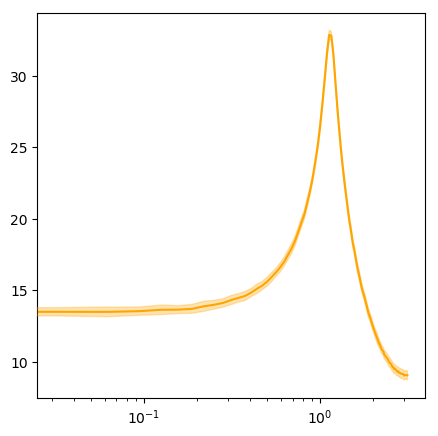

In [66]:
_, ax = plt.subplots(figsize=(5,5))

θ, γ = AR_distributions(pacf(signal[1], 1:3), 100000000*Ic(3), params[1]["a_gamma"], params[1]["b_gamma"])
mean_psd, std_psd = summary_psd(θ, γ)

# plot psd's
plot_psd(ax, mean_psd, std_psd)
plt.xscale("log")

## Perform source separation

In [68]:
function convert_parameters(params)
    params_new = Dict()
    for k=1:length(params)
        params_new[pad(:a_γ,k)] = params[k]["a_gamma"]
        params_new[pad(:b_γ,k)] = params[k]["b_gamma"]
        params_new[pad(:μ_θ,k)] = params[k]["mean_theta"]
        params_new[pad(:Λ_θ,k)] = params[k]["precision_theta"]
    end
    return params_new
end
;

In [69]:
function observation_model(k, AR_order)
    
    # create factor graph
    fg = FactorGraph()
        
    # create models and combine
    for ki = 1:k
        
        # create signal model
        model = signal_model(ki, AR_order)
        eval(model)
        
    end
    @RV xtot = sum([vars[pad(:x, ki)] for ki=1:k])
    
    # add observation noise
    @RV y ~ GaussianMeanPrecision(xtot, placeholder(:γ_meas))
    
    # create output samples
    placeholder(y, :y)
    qi =  vcat([expand([[vars[pad(:S,ki)], vars[pad(:Sprev,ki)]] for ki = 1:k])], expand([[vars[pad(:θ,ki)], vars[pad(:γ,ki)]] for ki = 1:k]))
    qids = vcat(:S, expand([[pad(:θ,ki), pad(:γ,ki)] for ki = 1:k]))
    
    q = ForneyLab.PosteriorFactorization(qi..., ids=qids)
    
    return fg, q
    
end
;

In [70]:
# convert parameters
paramsc = convert_parameters(params)

# load graph
fg, q = observation_model(length(sound_files), AR_order)

# create algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))

# specify priors
priors = load_priors(1:length(sound_files), AR_order, mode="separation")

# specify marginals
marginals = load_marginals(1:length(sound_files), AR_order)

# specify hyperparameters
hyper = Dict(:γ_meas => γ_meas_sep)
hyper = merge(hyper, paramsc)

# create dictionary for to inferred values
vals = Dict()

# separated signals
μ_separated = Array{Array{Float64,1},1}(undef, length(sound_files))
σ_separated = Array{Array{Float64,1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    μ_separated[k] = Array{Float64,1}(undef, length(ymix))
    σ_separated[k] = Array{Float64,1}(undef, length(ymix))
end

# loop through signal
for n = 1:length(ymix)
       
    # fill data dictionary
    data = merge(priors, hyper, vals, Dict(:y => ymix[n]))

    # perform updates
    for _ = 1:iterations

        # perform inference
        marginals = getfield(Main, Symbol("stepS!"))(data, marginals)
        for ki = 1:length(sound_files)
            marginals = getfield(Main, Symbol("stepθ_"*string(ki,pad=2)*"!"))(data, marginals)
            marginals = getfield(Main, Symbol("stepγ_"*string(ki,pad=2)*"!"))(data, marginals)
        end
    end

    # get new values
    for ki = 1:length(sound_files)
        vals[pad(:μ_Sprev, ki)] = ForneyLab.unsafeMean(marginals[pad(:S, ki)*pad(:_Sprev,ki)])[1:AR_order]
        vals[pad(:Λ_Sprev, ki)] = inv(ForneyLab.unsafeCov(marginals[pad(:S, ki)*pad(:_Sprev,ki)])[1:AR_order,1:AR_order])
    end
    
    # get separated signals
    for ki = 1:length(sound_files)
        μ_separated[ki][n] = vals[pad(:μ_Sprev, ki)][1]
        σ_separated[ki][n] = sqrt(ForneyLab.unsafeCov(marginals[pad(:S, ki)*pad(:_Sprev,ki)])[1,1])
    end
end    

## Analyze results

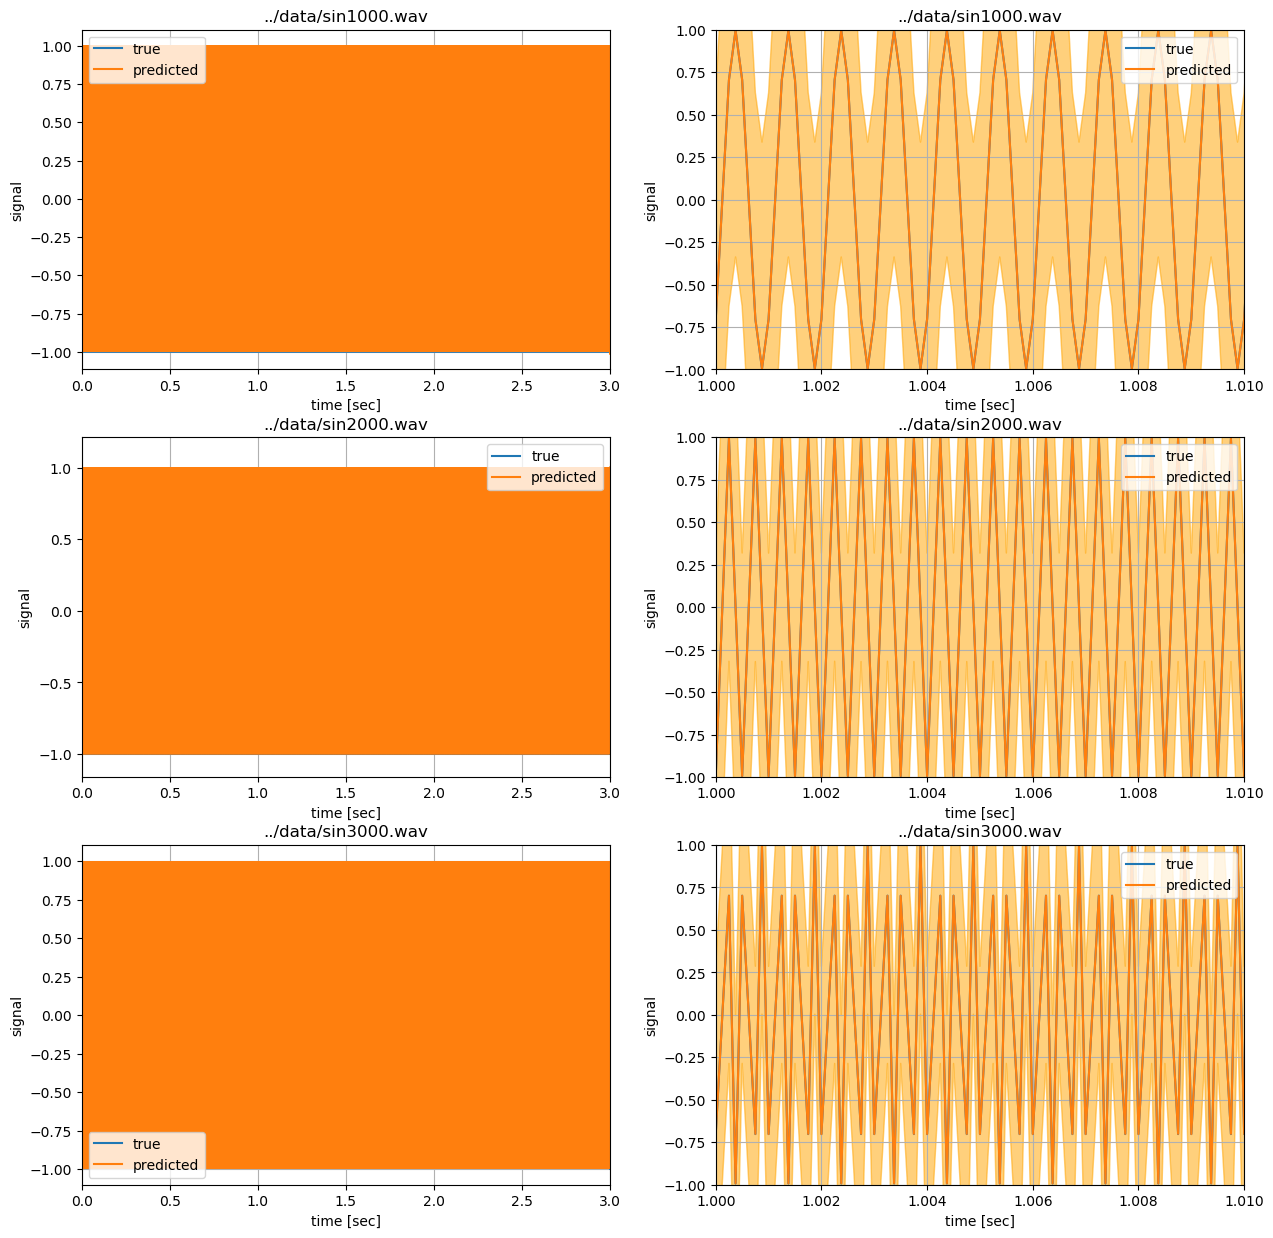

In [71]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t, signal[k], label="true")
    ax[k,1].plot(t, μ_separated[k], label="predicted")
    ax[k,2].fill_between(t, μ_separated[k] .- σ_separated[k], μ_separated[k] .+ σ_separated[k], alpha=0.3, color="orange")
    ax[k,1].set_xlim([0, duration]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k]), ax[k,1].legend()
    
    # plot zoomed-in version of signal
    ax[k,2].plot(t, signal[k], label="true")
    ax[k,2].plot(t, μ_separated[k], label="predicted")
    ax[k,2].fill_between(t, μ_separated[k] .- σ_separated[k], μ_separated[k] .+ σ_separated[k], alpha=0.3, color="orange")
    ax[k,2].set_xlim([1, 1.01]), ax[k,2].set_ylim(-1,1), ax[k,2].set_xlabel("time [sec]"), ax[k,2].set_ylabel("signal"), ax[k,2].grid(), ax[k,2].set_title(sound_files[k]), ax[k,2].legend()

end

# save figure
filename_figures1 = folder_figures*"/AR_time_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*string(AR_order, pad=2)*"_"*@sprintf("%.1E", γ_meas_sep)*".png"
plt.savefig(filename_figures1)

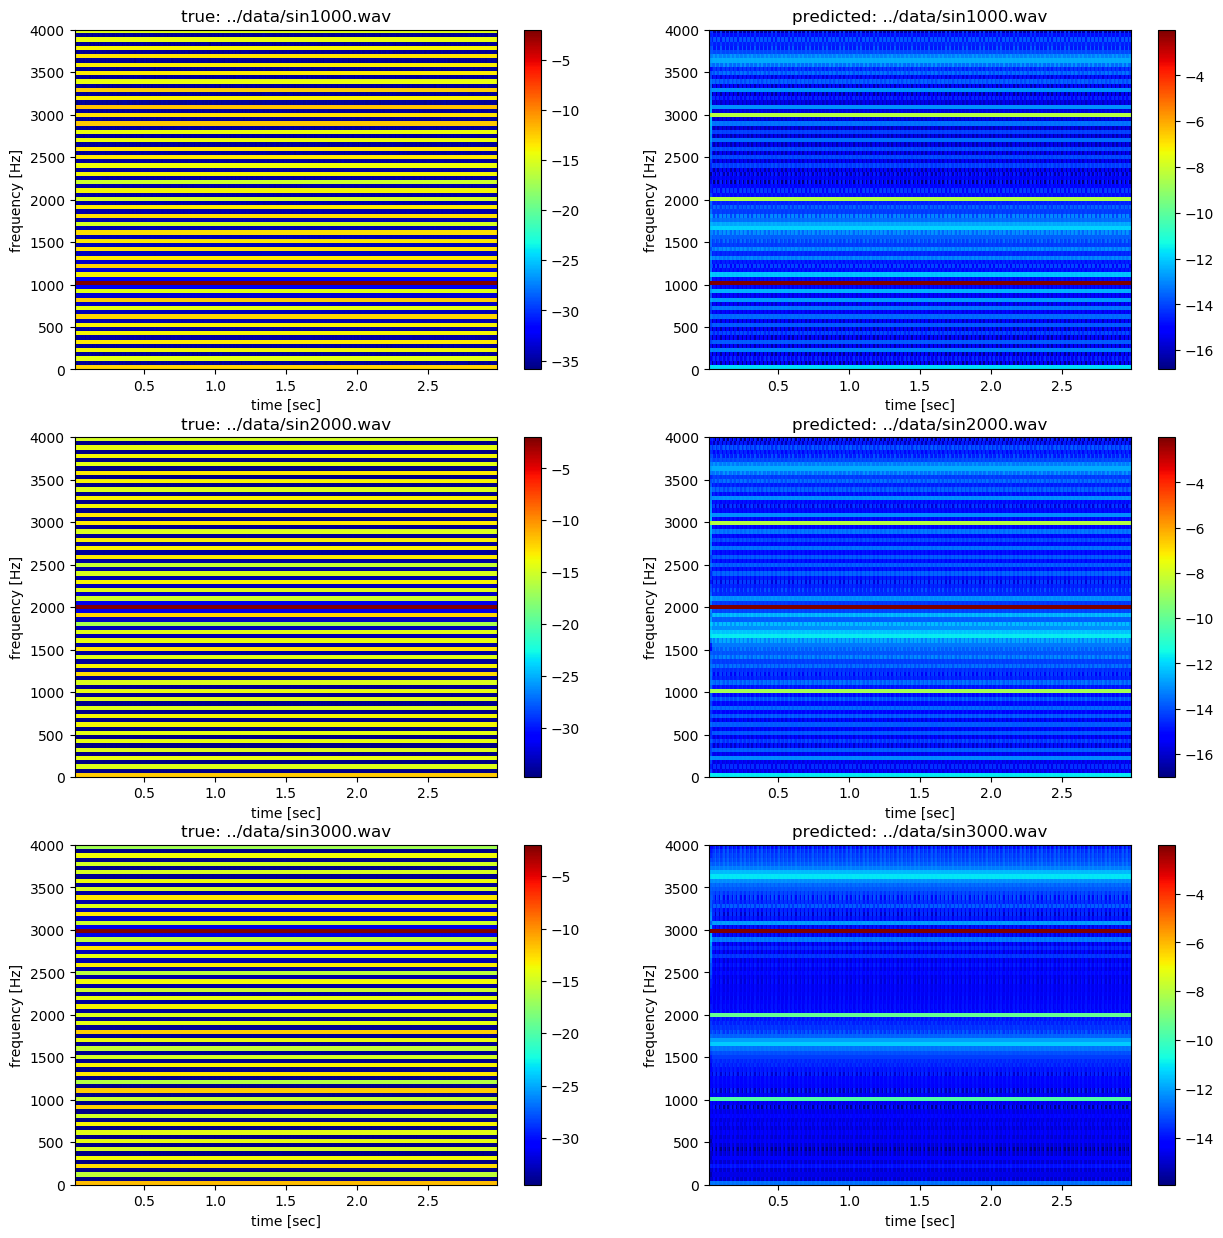

In [72]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot true spectrogram
    plot_spectrogram(spectrogram(signal[k], 160, 80, fs=fs_desired), fs_desired, ax=ax[k,1], colorbar=true)
    ax[k,1].set_title("true: "*sound_files[k])
    
    # plot predicted spectrogram
    plot_spectrogram(spectrogram(μ_separated[k], 160, 80, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true)
    ax[k,2].set_title("predicted: "*sound_files[k])

end

# save figure
filename_figures2 = folder_figures*"/AR_freq_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*string(AR_order, pad=2)*"_"*@sprintf("%.1E", γ_meas_sep)*".png"
plt.savefig(filename_figures2)